In [1]:
import requests, re, json, progressbar, yaml
import os
import pandas as pd
import datadotworld as dw
import numpy as np
import datetime 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#Pull data from data.world & describe columns
stat_data = dw.load_dataset("tatertot53/baseball-analysis",force_update=True)
stat_data.describe()

{'homepage': 'https://data.world/tatertot53/baseball-analysis',
 'name': 'tatertot53_baseball-analysis',
 'resources': [{'format': 'csv',
   'name': 'batting',
   'path': 'data/batting.csv'},
  {'format': 'csv',
   'name': 'bls_data_series',
   'path': 'data/bls_data_series.csv'},
  {'format': 'csv',
   'name': 'fangraphs_ss_data',
   'path': 'data/fangraphs_ss_data.csv'},
  {'format': 'csv', 'name': 'fielding', 'path': 'data/fielding.csv'},
  {'format': 'csv', 'name': 'salaries', 'path': 'data/salaries.csv'},
  {'format': 'csv', 'name': 'teams', 'path': 'data/teams.csv'},
  {'bytes': 6416242,
   'format': 'csv',
   'mediatype': 'text/csv',
   'name': 'original/Batting.csv',
   'path': 'original/Batting.csv'},
  {'bytes': 13354,
   'format': 'xlsx',
   'mediatype': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet',
   'name': 'original/CPI 1913 to 2018.xlsx',
   'path': 'original/CPI 1913 to 2018.xlsx'},
  {'bytes': 295360,
   'format': 'csv',
   'mediatype': 'text/cs

In [3]:
#Shows key values for DF creation
stat_data.dataframes

LazyLoadedDict({'batting': LazyLoadedValue(<pandas.DataFrame>), 'bls_data_series': LazyLoadedValue(<pandas.DataFrame>), 'fangraphs_ss_data': LazyLoadedValue(<pandas.DataFrame>), 'fielding': LazyLoadedValue(<pandas.DataFrame>), 'salaries': LazyLoadedValue(<pandas.DataFrame>), 'teams': LazyLoadedValue(<pandas.DataFrame>)})

In [4]:
#Create Batting DF
batting_df = stat_data.dataframes['batting']
batting_df.columns


C:\Users\ckent\Anaconda3\envs\PythonData\lib\site-packages\datadotworld\models\dataset.py:192: UserWarning: Unable to set data frame dtypes automatically using batting schema. Data types may need to be adjusted manually. Error: Integer column has NA values in column 12
  'Error: {}'.format(resource_name, e))


Index(['playerid', 'yearid', 'stint', 'teamid', 'lgid', 'g', 'ab', 'r', 'h',
       '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so', 'ibb', 'hbp', 'sh',
       'sf', 'gidp'],
      dtype='object')

In [5]:
#Create Salary DF
salary_df = stat_data.dataframes['salaries']

In [6]:
#Create Teams DF
teams_df = stat_data.dataframes['teams']

C:\Users\ckent\Anaconda3\envs\PythonData\lib\site-packages\datadotworld\models\dataset.py:192: UserWarning: Unable to set data frame dtypes automatically using teams schema. Data types may need to be adjusted manually. Error: Integer column has NA values in column 7
  'Error: {}'.format(resource_name, e))


In [7]:
#Create Fielding DF
fielding_df = stat_data.dataframes['fielding']

C:\Users\ckent\Anaconda3\envs\PythonData\lib\site-packages\datadotworld\models\dataset.py:192: UserWarning: Unable to set data frame dtypes automatically using fielding schema. Data types may need to be adjusted manually. Error: Integer column has NA values in column 7
  'Error: {}'.format(resource_name, e))


In [8]:
#Create FanGraphs Advanced Stats DF
fanGraphs_df = stat_data.dataframes['fangraphs_ss_data']
fanGraphs_df.columns

C:\Users\ckent\Anaconda3\envs\PythonData\lib\site-packages\datadotworld\models\dataset.py:192: UserWarning: Unable to set data frame dtypes automatically using fangraphs_ss_data schema. Data types may need to be adjusted manually. Error: Integer column has NA values in column 17
  'Error: {}'.format(resource_name, e))


Index(['season', 'name', 'team', 'g', 'pa', 'hr', 'r', 'rbi', 'sb', 'bb', 'k',
       'iso', 'babip', 'avg', 'obp', 'slg', 'woba', 'wrc', 'bsr', 'off', 'def',
       'war', 'playerid'],
      dtype='object')

In [9]:
#Rename columns & remove Unnecessary Columns
fanGraphs_df = fanGraphs_df.rename(columns={'season':'yearid','name':'fullname','team':'teamid'})

fanGraphs_df['nameFirst'] = fanGraphs_df.fullname.str.split(' ', expand=True)[0]
fanGraphs_df['nameLast'] = fanGraphs_df.fullname.str.split(' ', expand=True)[1]

advanced_batting = fanGraphs_df[['yearid','nameFirst','nameLast','hr','pa','teamid','babip','obp','slg',
                                 'woba','wrc','bsr','off','def','war']]
advanced_batting.head(10)


,yearid,nameFirst,nameLast,hr,pa,teamid,babip,obp,slg,woba,wrc,bsr,off,def,war
0,1991,Cal,Ripken,34,717,Orioles,0.304,0.374,0.566,0.405,154.0,0.8,46.9,31.8,10.6
1,2002,Alex,Rodriguez,57,725,Rangers,0.290,0.392,0.623,0.424,158.0,4.7,56.1,19.6,10.0
2,2000,Alex,Rodriguez,41,672,Mariners,0.333,0.420,0.606,0.431,158.0,1.3,54.4,22.6,9.5
3,1996,Alex,Rodriguez,36,677,Mariners,0.382,0.414,0.631,0.443,159.0,1.0,56.0,15.8,9.2
4,2003,Alex,Rodriguez,47,715,Rangers,0.305,0.396,0.600,0.416,151.0,4.3,50.3,18.2,9.2
5,1995,John,Valentin,27,621,Red Sox,0.296,0.399,0.533,0.405,138.0,1.6,32.6,30.4,8.2
6,1998,Alex,Rodriguez,42,748,Mariners,0.324,0.360,0.560,0.394,135.0,3.6,37.8,16.5,7.9
7,2001,Alex,Rodriguez,52,732,Rangers,0.325,0.399,0.622,0.425,159.0,2.3,56.6,-1.9,7.8
8,1987,Alan,Trammell,28,668,Tigers,0.335,0.402,0.551,0.407,152.0,3.0,47.0,8.0,7.7
9,2000,Nomar,Garciaparra,21,599,Red Sox,0.378,0.434,0.599,0.432,154.0,0.2,44.4,15.0,7.6


In [10]:
#Create People DF from CSV at data.world
names = pd.read_csv("people.csv")
names_df = pd.DataFrame(names)

In [11]:
#Check column names for Player Name DF
names_df.columns

Index(['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame',
       'retroID', 'bbrefID'],
      dtype='object')

In [12]:
#Change dtypes of "debut" and "finalGame"
names_df['debut'] = pd.to_datetime(names_df['debut'])  
names_df['finalGame'] = pd.to_datetime(names_df['finalGame'])
#names_df.info()

In [13]:
#Filter for all years >= 1985, remove unnecessary columns
# names_df = names_df[(names_df['debut'] >= datetime.date(1985,1,1)) | (names_df['finalGame'] >= datetime.date(1985,1,1))]
#names_df = names_df[names_df['finalGame'] >= datetime.date(1985,1,1)]
names_since_85 = names_df[['playerID','nameFirst','nameLast','nameGiven','debut','finalGame']]
names_since_85 = names_since_85.sort_values('finalGame')
#names_since_85.info()

In [14]:
#Check column names for Batting Stat DF
batting_df.columns

Index(['playerid', 'yearid', 'stint', 'teamid', 'lgid', 'g', 'ab', 'r', 'h',
       '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so', 'ibb', 'hbp', 'sh',
       'sf', 'gidp'],
      dtype='object')

In [15]:
#Rename "playerID" column to match other DFs, filter for all years >= 1985, and remove unnecessary columns.
batting_df = batting_df.rename(columns={'playerid':'playerID'})
batting_df['ba'] = batting_df['h'] / batting_df['ab']
batting_df['ba'] = batting_df['ba'].map('{:.3f}'.format)
batting_df = batting_df[batting_df['yearid'] >= 1985]
batting_since_85 = batting_df[['playerID','yearid','teamid','lgid','g','ab','ba','r','h','2b','3b','hr','rbi','sb','cs',
                               'bb','so','ibb','hbp','sh','sf','gidp']]
batting_since_85.sample(10)

,playerID,yearid,teamid,lgid,g,ab,ba,r,h,2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
68644,bosioch01,1991,ML4,AL,32,0,nan,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
67866,hillke01,1990,SLN,NL,17,19,0.211,0,4,0,...,1.0,0.0,0.0,1,5.0,0.0,1.0,5.0,0.0,0.0
81266,kingsge01,2001,SEA,AL,10,15,0.333,4,5,0,...,1.0,2.0,0.0,2,2.0,0.0,1.0,0.0,0.0,1.0
74323,burnije01,1996,ML4,AL,23,72,0.236,8,17,4,...,14.0,2.0,0.0,8,16.0,1.0,2.0,0.0,2.0,1.0
95903,danksjo01,2012,CHA,AL,9,3,0.000,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
102145,mariomi01,2016,PHI,NL,25,0,nan,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
68309,ryanno01,1990,TEX,AL,30,0,nan,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
64313,barrema02,1987,BOS,AL,137,559,0.293,72,164,23,...,43.0,15.0,2.0,51,38.0,0.0,1.0,22.0,5.0,11.0
100017,brookaa01,2015,KCA,AL,2,0,nan,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
79747,gwynnto01,2000,SDN,NL,36,127,0.323,17,41,12,...,17.0,0.0,1.0,9,4.0,2.0,1.0,0.0,3.0,4.0


In [16]:
#Check column names for Team Info DF
teams_df.columns

Index(['yearid', 'lgid', 'teamid', 'franchid', 'divid', 'rank', 'g', 'ghome',
       'w', 'l', 'divwin', 'wcwin', 'lgwin', 'wswin', 'r', 'ab', 'h', '2b',
       '3b', 'hr', 'bb', 'so', 'sb', 'cs', 'hbp', 'sf', 'ra', 'er', 'era',
       'cg', 'sho', 'sv', 'ipouts', 'ha', 'hra', 'bba', 'soa', 'e', 'dp', 'fp',
       'name', 'park', 'attendance', 'bpf', 'ppf', 'teamidbr',
       'teamidlahman45', 'teamidretro'],
      dtype='object')

In [17]:
#Filter for all years >= 1985, remove unnecessary columns
teams_df = teams_df[teams_df['yearid'] >= 1985]
teams_since_85 = teams_df[['yearid','rank','g','w','l','divwin','wswin','r','ab','h','2b','3b','hr','bb','so',
                     'sb','cs','hbp','sf','name']]
#teams_since_85.tail()

In [18]:
#Filter for all years >= 1985, rename PlayerID column to match other DFs
salary_df = salary_df[salary_df['yearid'] >= 1985]
salary_df = salary_df.rename(columns={'playerid':'playerID'})
salary_since_85 = salary_df[['yearid','playerID','salary']]
#salary_since_85.info()

In [19]:
#Check column names for Fielding Info DF
fielding_df.columns

Index(['playerid', 'yearid', 'stint', 'teamid', 'lgid', 'pos', 'g', 'gs',
       'innouts', 'po', 'a', 'e', 'dp', 'pb', 'wp', 'sb', 'cs', 'zr'],
      dtype='object')

In [20]:
#Filter for all years >= 1985, remove unnecessary columns
fielding_df = fielding_df.rename(columns={'playerid':'playerID'})
fielding_df = fielding_df[fielding_df['yearid'] >= 1985]
fielding_since_1985 = fielding_df[['playerID','yearid','pos','gs']]
#fielding_since_1985.head()

In [21]:
#Merging
merge_01 = pd.merge(names_since_85,salary_since_85, on='playerID', how='inner')
merge_01.sort_values('yearid')
merge_01.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26428 entries, 0 to 26427
Data columns (total 8 columns):
playerID     26428 non-null object
nameFirst    26428 non-null object
nameLast     26428 non-null object
nameGiven    26428 non-null object
debut        26428 non-null datetime64[ns]
finalGame    26428 non-null datetime64[ns]
yearid       26428 non-null int64
salary       26428 non-null int64
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 1.8+ MB


In [22]:
#Merging
merge_02 = pd.merge(merge_01,batting_since_85,on=['playerID','yearid'],how='inner')
merge_02.head()

,playerID,nameFirst,nameLast,nameGiven,debut,finalGame,yearid,salary,teamid,lgid,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
0,hasslan01,Andy,Hassler,Andrew Earl,1971-05-30,1985-05-07,1985,129166,SLN,NL,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,fordda01,Dan,Ford,Darnell Glenn,1975-04-12,1985-05-31,1985,450000,BAL,AL,...,1.0,0.0,1.0,7,17.0,0.0,0.0,0.0,0.0,3.0
2,tellmto01,Tom,Tellmann,Thomas John,1979-06-09,1985-06-02,1985,207500,OAK,AL,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,nolanjo01,Joe,Nolan,Joseph William,1972-09-21,1985-06-25,1985,341667,BAL,AL,...,6.0,0.0,0.0,5,5.0,1.0,0.0,0.0,1.0,1.0
4,zahnge01,Geoff,Zahn,Geoffrey Clayton,1973-09-02,1985-08-14,1985,550000,CAL,AL,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Merging
merge_03 = pd.merge(merge_02,fielding_since_1985,on=['playerID','yearid'],how='inner')
#merge_03.info()

In [24]:
merge_03.columns

Index(['playerID', 'nameFirst', 'nameLast', 'nameGiven', 'debut', 'finalGame',
       'yearid', 'salary', 'teamid', 'lgid', 'g', 'ab', 'ba', 'r', 'h', '2b',
       '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so', 'ibb', 'hbp', 'sh', 'sf',
       'gidp', 'pos', 'gs'],
      dtype='object')

In [25]:
final_df = merge_03[merge_03['pos'] == 'SS']
final_df = final_df.sort_values('yearid')
#final_df.info()

In [26]:
year_counts = final_df['yearid'].value_counts()
year_counts

1996    133
1998    130
2013    126
2006    119
2000    119
1995    117
1993    117
2005    116
1999    116
2004    110
1997    110
2003    109
1989    109
2007    109
2002    109
2001    108
2010    106
2012    105
2011    102
2009    101
2014    101
1992    100
2016     98
2008     97
1986     94
1987     94
1994     93
1990     93
2015     92
1988     84
1991     73
1985     69
Name: yearid, dtype: int64

QUESTION #1 - JORDAN'S CODE

In [27]:
#Advanced Stats playerID match
id_match = pd.merge(names_since_85,advanced_batting,on=['nameFirst','nameLast'],how='inner')
id_match = id_match[['playerID','nameFirst','nameLast','debut','finalGame','yearid','pa','babip','obp','slg','woba','wrc','bsr',
                    'off','def','war']]
id_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2664 entries, 0 to 2663
Data columns (total 16 columns):
playerID     2664 non-null object
nameFirst    2664 non-null object
nameLast     2664 non-null object
debut        2652 non-null datetime64[ns]
finalGame    2652 non-null datetime64[ns]
yearid       2664 non-null int64
pa           2664 non-null int64
babip        2664 non-null float64
obp          2664 non-null float64
slg          2664 non-null float64
woba         2664 non-null float64
wrc          2659 non-null float64
bsr          2664 non-null float64
off          2664 non-null float64
def          2664 non-null float64
war          2664 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(2), object(3)
memory usage: 353.8+ KB


In [28]:
all_stats = pd.merge(id_match,final_df,on=['playerID','yearid'],how='inner')
all_stats.columns

Index(['playerID', 'nameFirst_x', 'nameLast_x', 'debut_x', 'finalGame_x',
       'yearid', 'pa', 'babip', 'obp', 'slg', 'woba', 'wrc', 'bsr', 'off',
       'def', 'war', 'nameFirst_y', 'nameLast_y', 'nameGiven', 'debut_y',
       'finalGame_y', 'salary', 'teamid', 'lgid', 'g', 'ab', 'ba', 'r', 'h',
       '2b', '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so', 'ibb', 'hbp', 'sh',
       'sf', 'gidp', 'pos', 'gs'],
      dtype='object')

In [29]:
all_stats=all_stats.rename(columns={'nameFirst_x':'First Name','nameLast_x':'Last Name','yearid':'Season','salary':'Salary',
                                   'teamid':'Team','lgid':'League','war':'WAR'})
all_stats=all_stats[['playerID','First Name','Last Name','Season','Salary','Team','League','WAR','off','def','g','ab','ba','pa',
                     'r','h','2b','3b','hr','rbi','sb','cs','bb','so','ibb','hbp','sh','sf','gidp','pos','gs','babip','obp',
                     'slg','woba','wrc','bsr']]
all_stats = all_stats.sort_values('Season')
all_stats.head()

,playerID,First Name,Last Name,Season,Salary,Team,League,WAR,off,def,...,sf,gidp,pos,gs,babip,obp,slg,woba,wrc,bsr
103,lemasjo01,Johnnie,LeMaster,1985,500000,CLE,AL,-1.2,-13.7,-1.3,...,0.0,0.0,SS,5.0,0.157,0.180,0.160,0.151,-14.0,-0.2
171,santara01,Rafael,Santana,1985,125000,NYN,NL,-0.1,-22.6,3.3,...,2.0,14.0,SS,145.0,0.284,0.295,0.302,0.262,65.0,0.0
173,romered01,Ed,Romero,1985,290000,ML4,AL,-0.1,-7.9,-2.6,...,0.0,3.0,SS,37.0,0.273,0.321,0.303,0.289,77.0,-0.3
267,thondi01,Dickie,Thon,1985,675000,HOU,NL,0.7,-4.3,1.7,...,2.0,2.0,SS,68.0,0.289,0.299,0.355,0.288,85.0,0.3
85,bowala01,Larry,Bowa,1985,525000,CHN,NL,0.3,-11.8,7.5,...,1.0,3.0,SS,3.0,0.259,0.276,0.304,0.258,54.0,0.5


In [30]:
all_stats.columns

Index(['playerID', 'First Name', 'Last Name', 'Season', 'Salary', 'Team',
       'League', 'WAR', 'off', 'def', 'g', 'ab', 'ba', 'pa', 'r', 'h', '2b',
       '3b', 'hr', 'rbi', 'sb', 'cs', 'bb', 'so', 'ibb', 'hbp', 'sh', 'sf',
       'gidp', 'pos', 'gs', 'babip', 'obp', 'slg', 'woba', 'wrc', 'bsr'],
      dtype='object')

In [31]:
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.axes import Subplot


Text(0.5,0,'WAR')

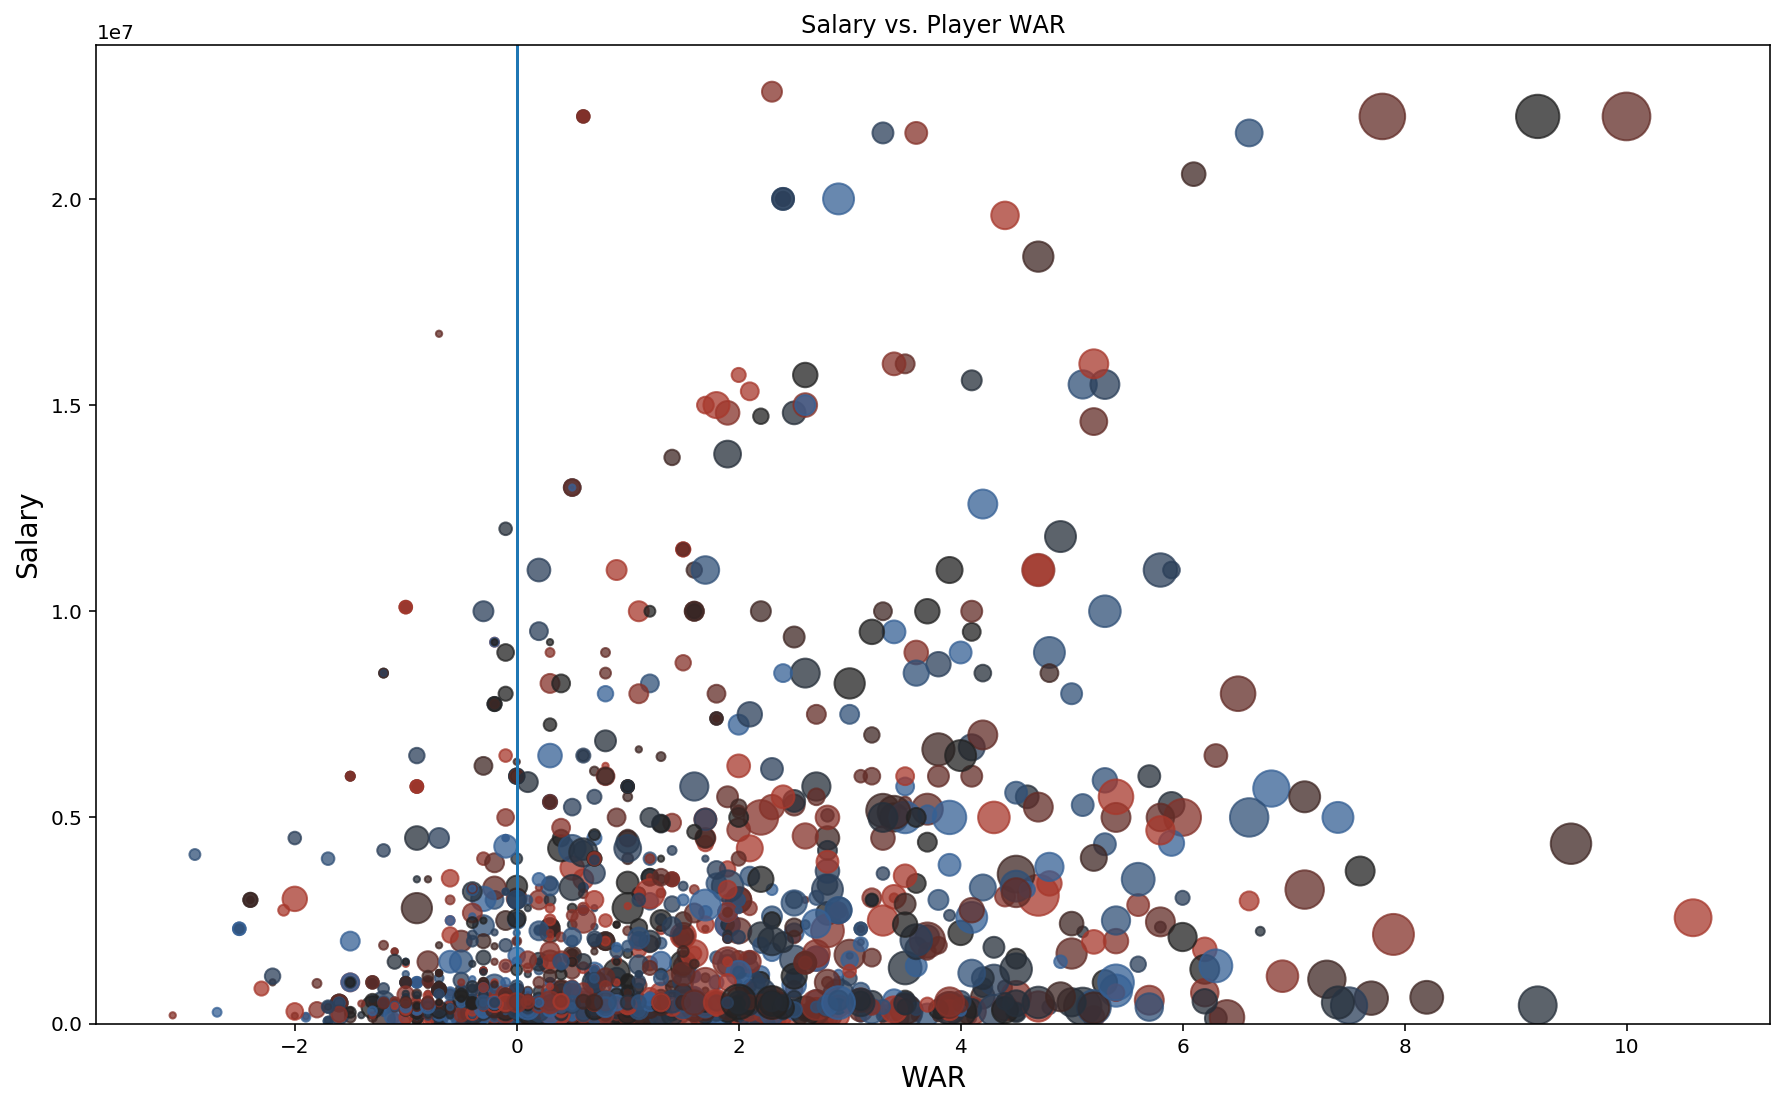

In [32]:
colors = sns.diverging_palette(250, 15, s=75, l=40,n=9, center="dark");

plt.figure(figsize=(20,8))

fig, ax = plt.subplots(1)
fig.set_size_inches((15, 9))


y = all_stats['Salary']
x = all_stats['WAR']
HR = all_stats['hr']

ax.scatter(x,y,c=colors,alpha=0.75,s=HR*10)

# Incorporate the other graph properties
ax.set_ylim([0,None])
ax.axvline(0,0)
ax.set_title("Salary vs. Player WAR")
ax.set_ylabel("Salary",fontsize=14)
ax.set_xlabel("WAR",fontsize=14)


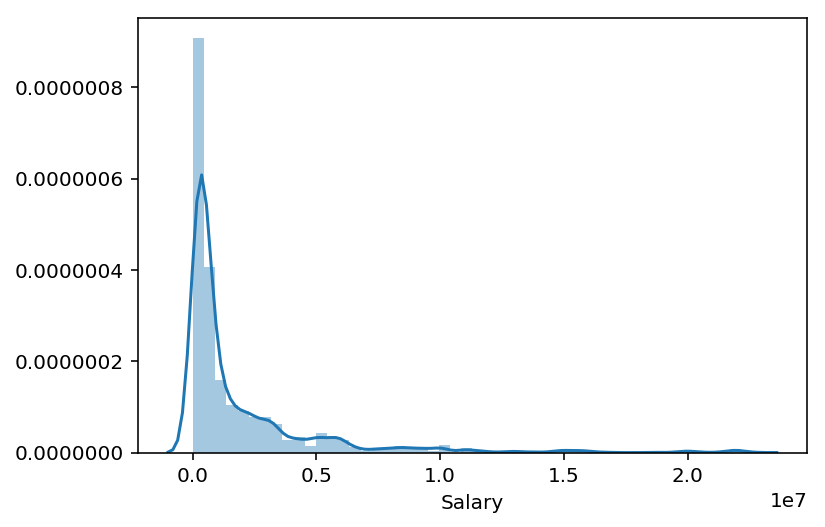

In [33]:
salary_histo = sns.distplot(y)
salary_histo
    

In [34]:
aggs = {'First Name':'first',
       'Last Name':'first',
       'Salary':'sum',
       'WAR':'sum',
       'off':'sum',
       'def':'sum',
       'g':'sum',
       'ab':'sum',
       'pa':'sum',   
       'r':'sum',
       'h':'sum',
       '2b':'sum',
       '3b':'sum',
       'hr':'sum',
       'rbi':'sum',
       'bb':'sum',
       'ibb':'sum',
       'hbp':'sum',
       'sf':'sum'}

by_playerID_df = all_stats.groupby(['playerID']).agg(aggs)
by_playerID_df['ba'] = by_playerID_df['h'] / by_playerID_df['ab']
by_playerID_df['obp'] = (by_playerID_df['h']+by_playerID_df['bb']+by_playerID_df['hbp'])/by_playerID_df['pa']
by_playerID_df['ba'] = by_playerID_df['ba'].map('{:.3f}'.format)
by_playerID_df['obp'] = by_playerID_df['obp'].map('{:.3f}'.format)
by_playerID_df.head()

,First Name,Last Name,Salary,WAR,off,def,g,ab,pa,r,...,2b,3b,hr,rbi,bb,ibb,hbp,sf,ba,obp
playerID,,,,,,,,,,,,,,,,,,,,,
abbotku01,Kurt,Abbott,5687000,-1.5,-48.2,-39.5,589,1700,2285,223,...,87,20,53,195.0,115,8.0,18.0,14.0,0.251,0.245
abreuto01,Tony,Abreu,407000,-1.1,-17.0,0.2,81,193,201,16,...,11,1,1,13.0,4,0.0,0.0,4.0,0.233,0.244
adamecr01,Cristhian,Adames,509500,-1.0,-15.9,-1.7,121,225,256,25,...,7,3,2,17.0,24,0.0,4.0,0.0,0.218,0.301
adamsru01,Russ,Adams,659000,-0.3,-21.4,-10.0,229,732,825,99,...,41,6,11,91.0,72,1.0,4.0,11.0,0.243,0.308
adriaeh01,Ehire,Adrianza,512500,0.2,-2.3,1.9,40,63,71,3,...,2,0,2,7.0,2,0.0,2.0,0.0,0.254,0.282


In [35]:
by_playerID_df[['WAR','off','def','rbi','ibb','hbp','sf']] = by_playerID_df[['WAR','off','def','rbi','ibb','hbp','sf']].astype('int64')
by_playerID_df.dtypes

First Name    object
Last Name     object
Salary         int64
WAR            int64
off            int64
def            int64
g              int64
ab             int64
pa             int64
r              int64
h              int64
2b             int64
3b             int64
hr             int64
rbi            int64
bb             int64
ibb            int64
hbp            int64
sf             int64
ba            object
obp           object
dtype: object

In [49]:
salary_total = by_playerID_df['Salary']
war_total = by_playerID_df['WAR']
hr_total = by_playerID_df['hr']
batting_avg = by_playerID_df['ba']
on_base = by_playerID_df['obp']
games = by_playerID_df['g']

war_color = sns.diverging_palette(125, 25, s=60, l=20,n=9, center="dark")
hr_color = sns.diverging_palette(450, 355, s=80, l=10,n=6, center="light")
ba_color = sns.diverging_palette(225, 5, s=20, l=40,n=9, center="dark")
obp_color = sns.diverging_palette(300, 40, s=40, l=60,n=9, center="dark")
games_color = sns.diverging_palette(175, 30, s=70, l=10,n=9, center="dark")

#war_color = sns.palplot(sns.diverging_palette(220, 10, sep=10, n=7, l=15,center="dark", as_cmap=True))
#x_cols = [(war_total,hr_total,batting_avg,on_base) for salary in salary_total]

#type(war_total)

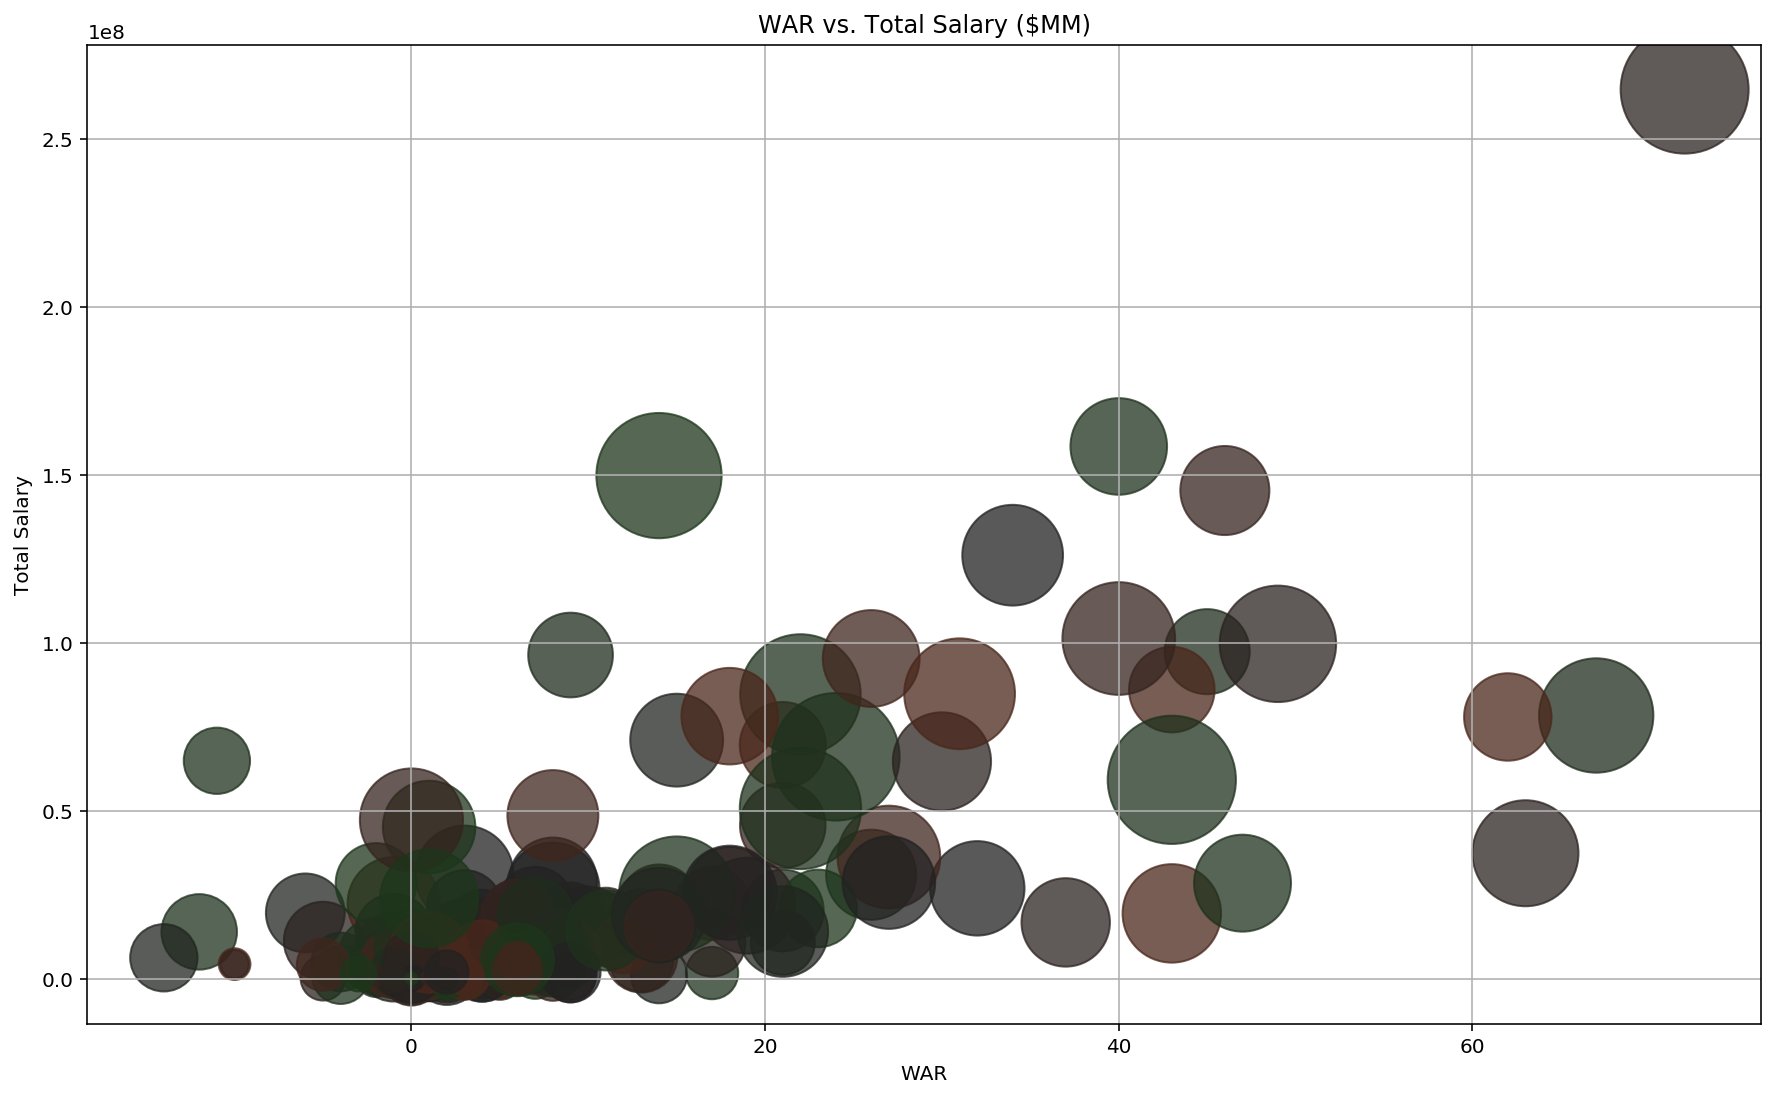

In [50]:
plt.figure(figsize=(20,8))

fig, ax = plt.subplots(1)
fig.set_size_inches((15, 9))

ax.scatter(war_total,salary_total,c=war_color,s=games*1.5,alpha=0.75,label='Games')

# Incorporate the other graph properties
ax.set_title("WAR vs. Total Salary ($MM)")
ax.set_ylabel("Total Salary")
ax.set_xlabel("WAR")
ax.grid(True)

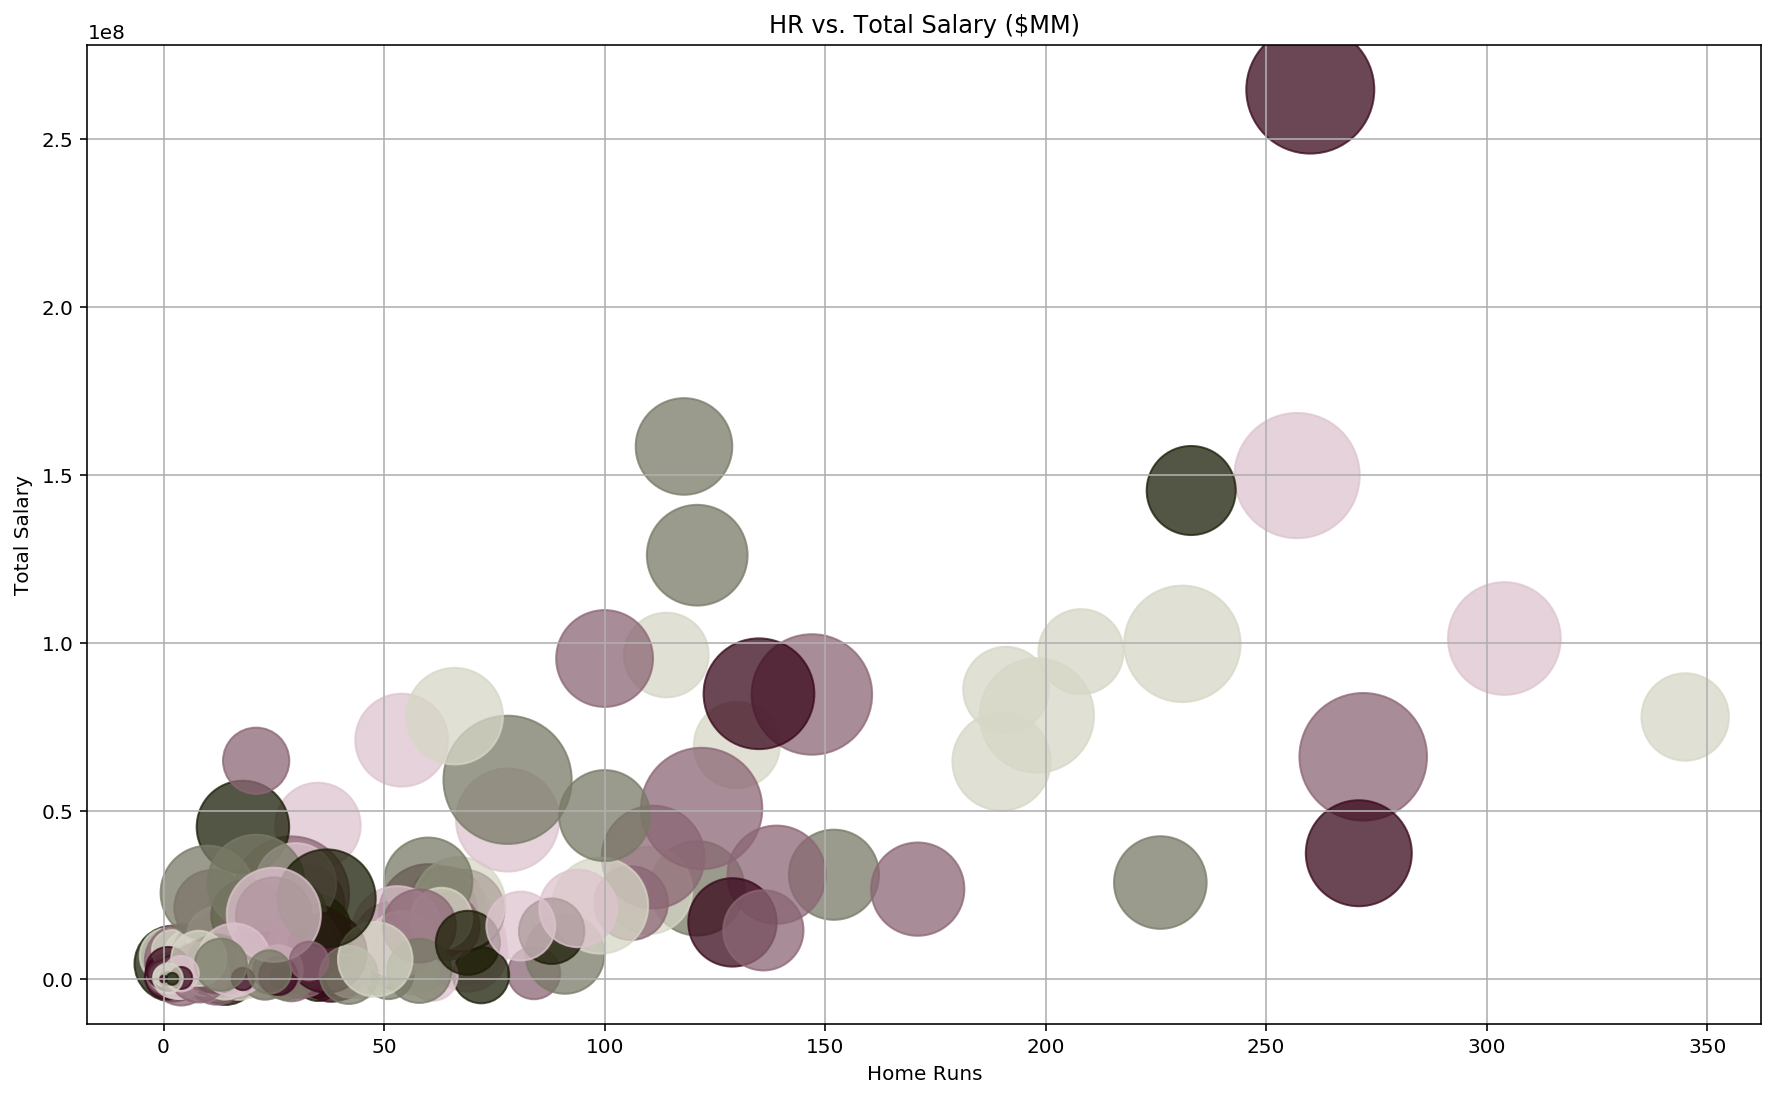

In [51]:
plt.figure(figsize=(20,8))

fig, ax = plt.subplots(1)
fig.set_size_inches((15, 9))

ax.scatter(hr_total,salary_total,c=hr_color,s=games*1.5,alpha=0.75,label='Games')

# Incorporate the other graph properties
ax.set_title("HR vs. Total Salary ($MM)")
ax.set_ylabel("Total Salary")
ax.set_xlabel("Home Runs")
ax.grid(True)

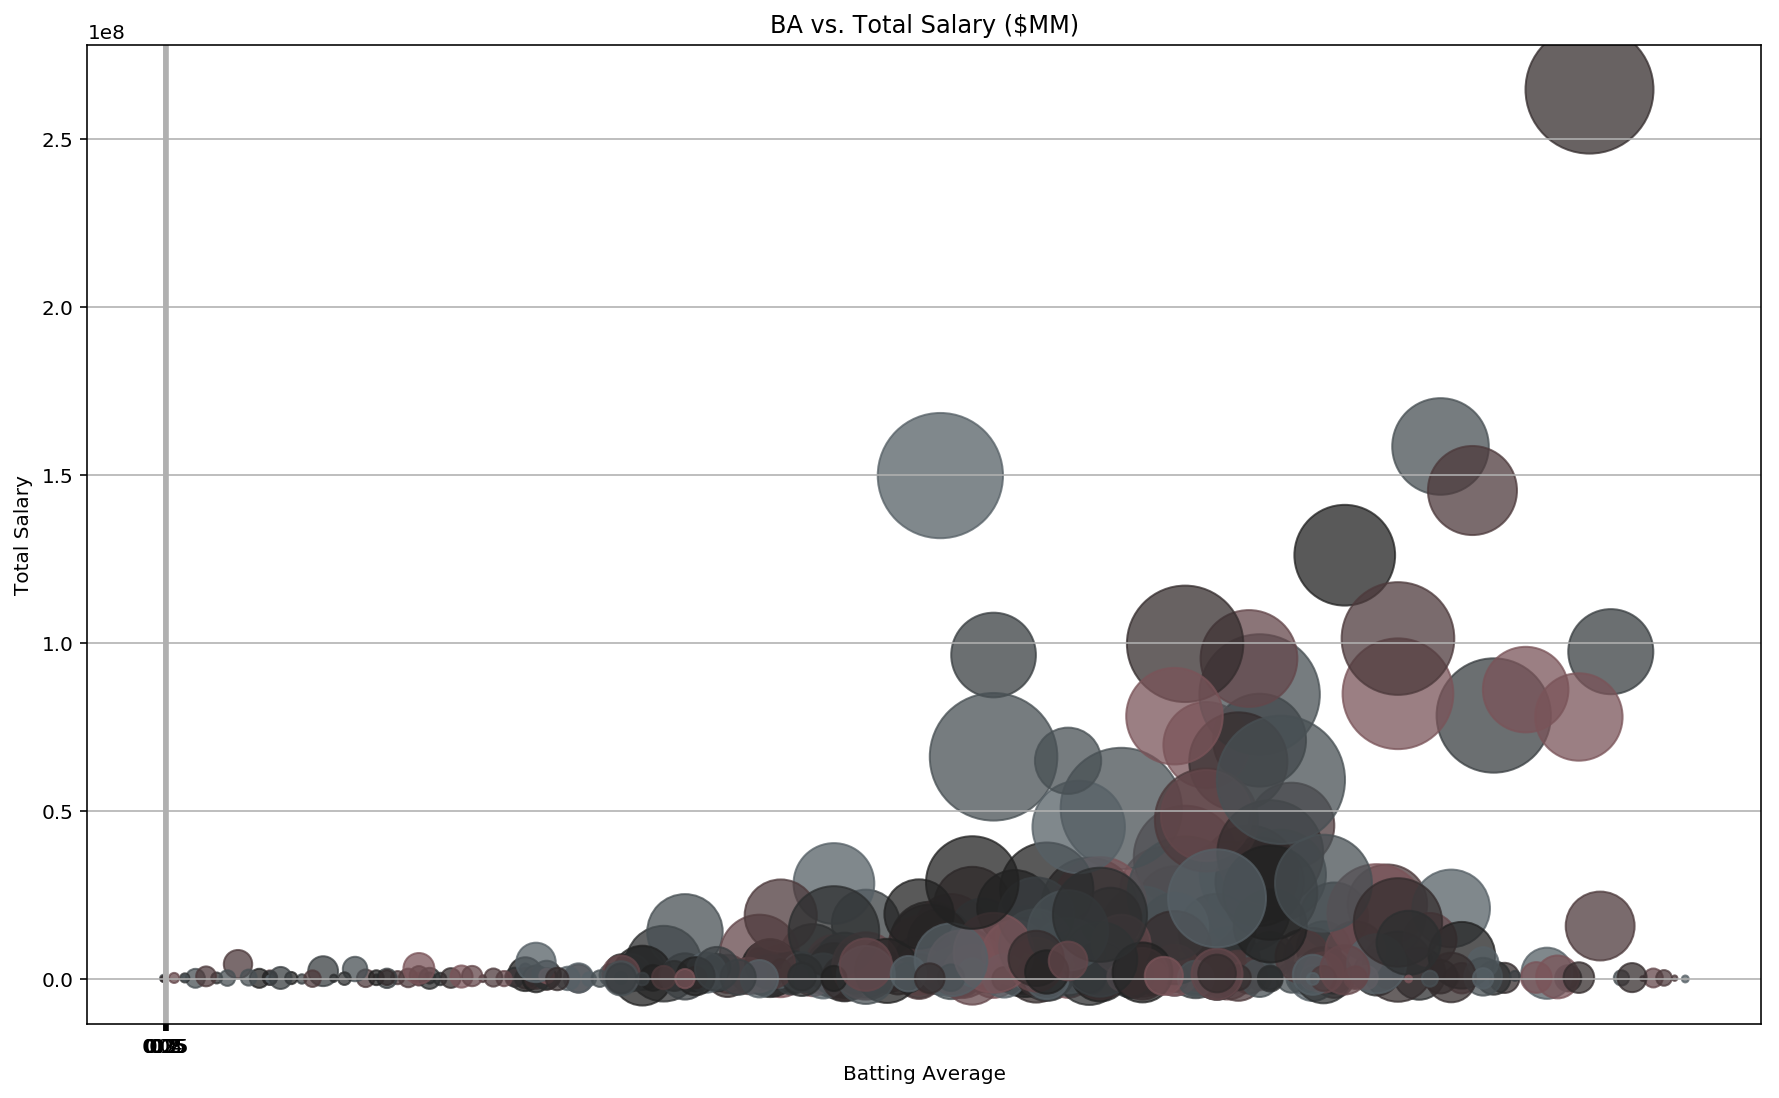

In [59]:
from matplotlib.ticker import FormatStrFormatter

# ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# ax.yaxis.set_ticks(np.arange(-2, 2, 0.25))

plt.figure(figsize=(20,8))

fig, ax = plt.subplots(1)
fig.set_size_inches((15, 9))

ax.scatter(batting_avg,salary_total,c=ba_color,s=games*1.5,alpha=0.75,label='Games')

# Incorporate the other graph properties
ax.set_title("BA vs. Total Salary ($MM)")
ax.set_ylabel("Total Salary")
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_ticks(np.arange(0,.50,0.50))
ax.set_xlabel("Batting Average")
ax.set_xticks([0,.050,.100,.150,.200,.250,.300,.350,.400],minor=False)
# ax.set_xlim([0,.50])
ax.grid(True)

In [38]:
x_cols = [(by_playerID_df['WAR'],by_playerID_df['hr'],by_playerID_df['ba'],
           by_playerID_df['obp']) for item in by_playerID_df]
y = [_ for item in salary_total]

x_cols = pd.np.array(x_cols)

color_list = [plt.get_cmap('spectral'), plt.get_cmap('Accent'), plt.get_cmap('PuBuGn_r'), plt.get_cmap('gist_earth_r')]
x_labels = ['WAR','HR','Batting AVG','OBP']

#print(y.shape)

C:\Users\ckent\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TypeError: float() argument must be a string or a number, not 'numpy.dtype'

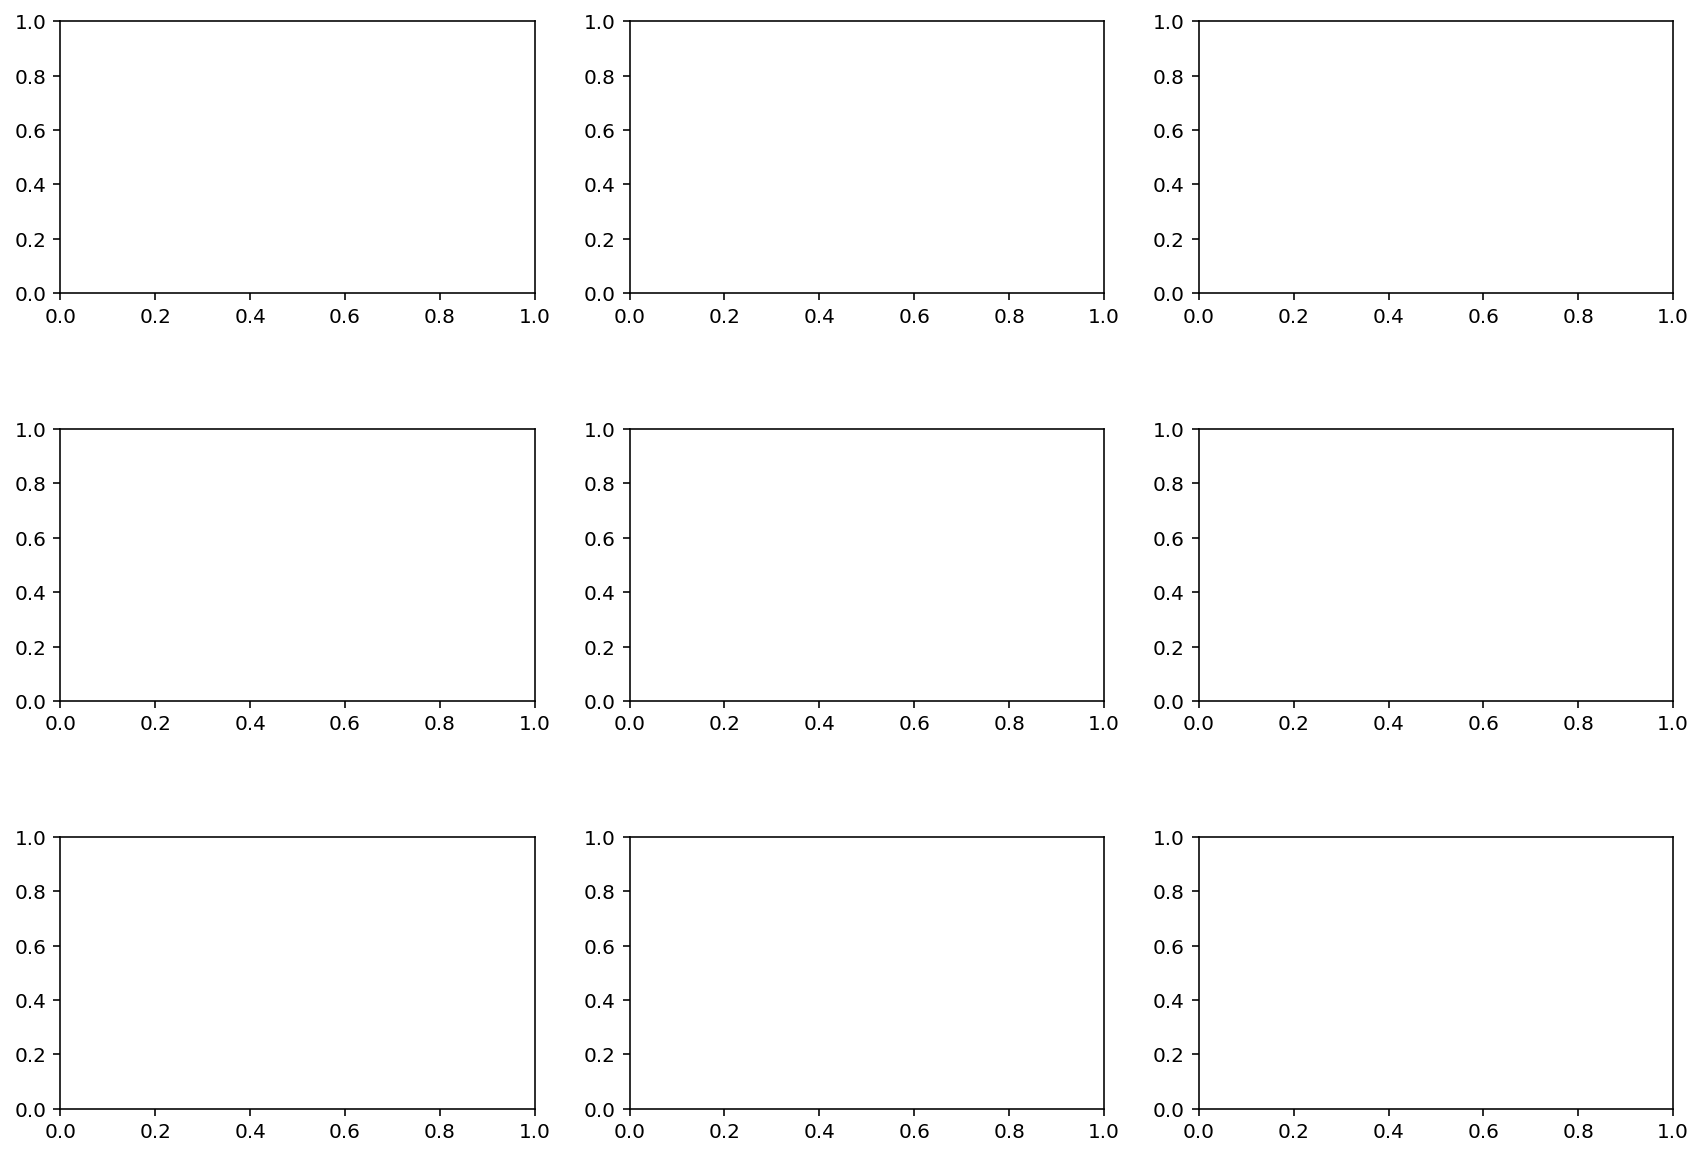

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches((16,10))
fig.subplots_adjust(left=0.2, wspace=0.2, hspace=.5)

ax_num = 0
for row in axes:
    for ax in row:

        x = x_cols[:,ax_num]
        #y = y_vars[ax_num]
        ax.scatter(x, y, c = y, cmap=color_list[ax_num])
        ax.axvline(0,0)
        
        title_x = re.sub(x_labels[ax_num])
        title = "Cumulative Salary vs. {0} ({1})".format(title_x)
        
        ax.set_title(title)
        ax.set_xlabel(x_labels[ax_num])
        ax.set_ylabel("Salary (Millions)")
        
        ax_num += 1

In [ ]:
from ipywidgets import interact
df = all_stats

sns.jointplot('hr', 'Salary', data=df)   # Color by evolution stage
plt.ylim(0, None)
plt.xlim(0, 75)

interact(s)